In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [9]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

In [10]:
task = [
    'PhonemeSequence',
    'SentenceRep',
    'TIMIT',
    'LexicalDelay'
]
ref='bipolar'

stats_paths = []
stats_paths.extend(
    BIDSPath(
        root=f'../results/{t}({ref})',
        datatype='HGA',
        suffix='coord',
        check=False,
    ).match()
    for t in task
)

stats_paths = np.concatenate(stats_paths).tolist()

coords = []
for path in tqdm(stats_paths):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)

# rename INS to 'Insula'
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
coords.loc[coords.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'PrG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'PoG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'Subcentral', 'roi'] = 'SMC'

coords.head()

100%|██████████| 663/663 [00:06<00:00, 107.60it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,phase,label,roi,hemi
0,D0019_ROG1-2,20.731562,-95.433053,-4.406237,-0.042141,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
1,D0019_ROG2-3,18.712896,-94.417750,6.523434,0.028593,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
2,D0019_ROG3-4,17.039880,-94.822626,17.317047,0.061983,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
3,D0019_ROG4-5,16.298644,-91.860079,29.446276,0.060467,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R
4,D0019_ROG5-6,13.397947,-84.402838,39.447554,0.018777,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R


In [11]:
# 先选出 Insula 的 unique 电极
coords_unique = coords[coords.roi.isin(['Insula'])].drop_duplicates(subset=['channel'])

# # 只保留 G_insular_short 和 G_Ins_lg_and_S_cent_ins
# coords_unique = coords_unique[
#     coords_unique.label.str.contains('G_insular_short') |
#     coords_unique.label.str.contains('G_Ins_lg_and_S_cent_ins')
# ]

print('Number of electrodes: ', coords_unique.shape[0])
coords_unique.label.unique()

Number of electrodes:  317


array(['ctx_lh_S_circular_insula_inf', 'ctx_rh_S_circular_insula_sup',
       'ctx_lh_G_insular_short', 'ctx_lh_G_Ins_lg_and_S_cent_ins',
       'ctx_lh_S_circular_insula_sup', 'ctx_lh_S_circular_insula_ant',
       'ctx_rh_G_Ins_lg_and_S_cent_ins', 'ctx_rh_S_circular_insula_inf',
       'ctx_rh_G_insular_short', 'ctx_rh_S_circular_insula_ant'],
      dtype=object)

# All Electrodes 3D

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot
Left insula center: [-37.56746079   1.01293045   0.2891795 ]
Right insula center: [39.04292212  2.16519823 -0.51819276]


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 18:29:48.072 ( 947.726s) [    7FA778894440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6a2f4f0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 18:29:48.275 ( 947.929s) [    7FA778894440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6a2f4f0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: eg

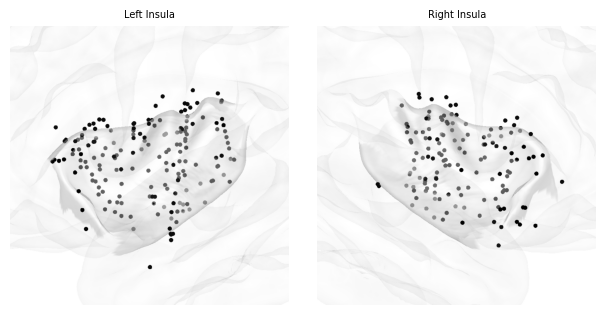

In [12]:
# 3D Brain with highlighted Insula (aparc.a2009s) - Electrodes at real positions
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 
                   'S_circular_insula_sup']

# 加载pial表面获取insula中心坐标
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

print(f"Left insula center: {lh_insula_center}")
print(f"Right insula center: {rh_insula_center}")

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# 电极数据
cord = coords_unique[['x', 'y', 'z']].values
mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 添加左半球电极（真实位置）
if mask_lh.any():
    lh_cord = cord[mask_lh]
    cloud = pv.PolyData(lh_cord)
    lh_brain._renderer.plotter.add_mesh(
        cloud,
        render_points_as_spheres=True,
        point_size=12,
        color='black',
        lighting=False,
    )

# 添加右半球电极（真实位置）
if mask_rh.any():
    rh_cord = cord[mask_rh]
    cloud = pv.PolyData(rh_cord)
    rh_brain._renderer.plotter.add_mesh(
        cloud,
        render_points_as_spheres=True,
        point_size=12,
        color='black',
        lighting=False,
    )

# 设置视角 - 聚焦在insula中心
# 使用 focalpoint 参数让相机对准 insula 中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, 
                   focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, 
                   focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.show()

Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 18:29:57.213 ( 956.867s) [    7FA778894440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1d510e80): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-15 18:29:57.381 ( 957.035s) [    7FA778894440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1d510e80): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

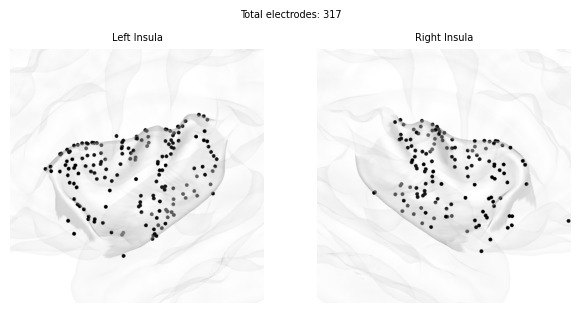

In [13]:
# 3D Brain with highlighted Insula (aparc.a2009s) - Electrodes projected to surface
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)


# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# 电极数据
cord = coords_unique[['x', 'y', 'z']].values
mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 添加左半球电极（投影到表面）
if mask_lh.any():
    lh_cord = cord[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_proj = lh_pial_coords[lh_indices]
    cloud = pv.PolyData(lh_cord_proj)
    lh_brain._renderer.plotter.add_mesh(
        cloud,
        render_points_as_spheres=True,
        point_size=12,
        color='black',
        lighting=False,
    )

# 添加右半球电极（投影到表面）
if mask_rh.any():
    rh_cord = cord[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_proj = rh_pial_coords[rh_indices]
    cloud = pv.PolyData(rh_cord_proj)
    rh_brain._renderer.plotter.add_mesh(
        cloud,
        render_points_as_spheres=True,
        point_size=12,
        color='black',
        lighting=False,
    )

# 设置视角 - 聚焦在insula中心
# 使用 focalpoint 参数让相机对准 insula 中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, 
                   focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, 
                   focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

plt.suptitle("Total electrodes: {}".format(coords_unique.shape[0]), fontsize=fontsize)
lh_brain.close()
rh_brain.close()

plt.tight_layout()

fig.savefig("../img/fig1/fig1_local_insula_all_electrodes.svg", dpi=300, bbox_inches='tight')
plt.show()

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


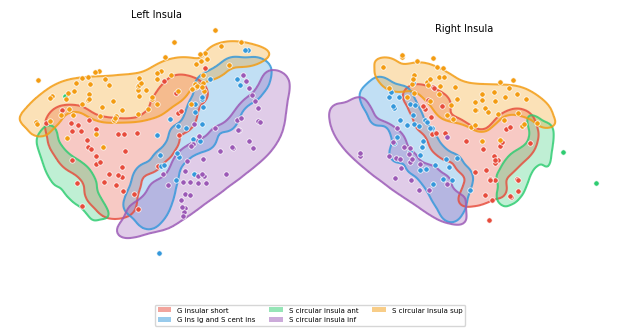

In [16]:
# 展示所有insula label groups
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 读取labels
labels = mne.read_labels_from_annot('fsaverage', parc='aparc.a2009s', hemi='both', subjects_dir=recon_dir)

# 所有insula相关的label及其颜色
insula_labels = {
    'G_insular_short': '#E74C3C',           # 红色 - 短回
    'G_Ins_lg_and_S_cent_ins': '#3498DB',   # 蓝色 - 长回和中央沟
    'S_circular_insula_ant': '#2ECC71',     # 绿色 - 前环岛沟
    'S_circular_insula_inf': '#9B59B6',     # 紫色 - 下环岛沟
    'S_circular_insula_sup': '#F39C12',     # 橙色 - 上环岛沟
}

# 加载pial表面
lh_coords_pial, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_coords_pial, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")

def get_label_coords(labels, label_name, hemi, coords_pial):
    for lab in labels:
        if lab.hemi == hemi and label_name in lab.name:
            return coords_pial[lab.vertices]
    return np.array([])

# 获取所有insula电极（包括sulci）
coords_all_insula = coords[coords.roi.isin(['Insula'])].drop_duplicates(subset=['channel'])
cord_all = coords_all_insula[['x', 'y', 'z']].values
elec_labels_all = coords_all_insula['label'].values

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

for ax, hemi, flip in zip(axes, ['lh', 'rh'], [True, False]):
    coords_pial = lh_coords_pial if hemi == 'lh' else rh_coords_pial
    
    # 绘制每个label区域
    for label_name, color in insula_labels.items():
        coords_region = get_label_coords(labels, label_name, hemi, coords_pial)
        if len(coords_region) > 0:
            draw_smooth_region(np.column_stack(project_2d(coords_region)), ax, color, alpha=0.3)
    
    # 绘制电极（按label着色）
    mask = cord_all[:, 0] < 0 if hemi == 'lh' else cord_all[:, 0] > 0
    if mask.any():
        for label_name, color in insula_labels.items():
            elec_mask = mask & np.array([label_name in str(l) for l in elec_labels_all])
            if elec_mask.any():
                y, z = project_2d(cord_all[elec_mask])
                ax.scatter(y, z, s=15, c=color, zorder=10, edgecolors='white', linewidths=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f"{'Left' if hemi == 'lh' else 'Right'} Insula", fontsize=fontsize)
    if flip:
        ax.invert_xaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 图例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, alpha=0.5, label=n.replace('_', ' ')) for n, c in insula_labels.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# All electrodes in local insula (anterior-posterior)

Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


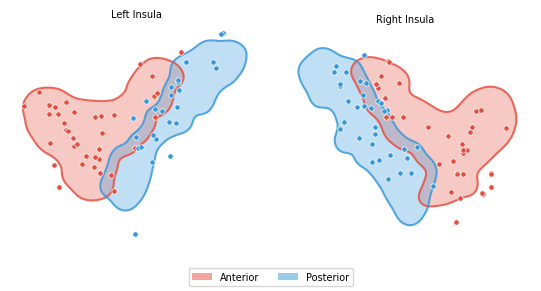

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 读取labels并获取anterior/posterior insula顶点
labels = mne.read_labels_from_annot('fsaverage', parc='aparc.a2009s', hemi='both', subjects_dir=recon_dir)

def get_label_vertices(labels, name_pattern, hemi):
    for lab in labels:
        if lab.hemi == hemi and name_pattern in lab.name:
            return set(lab.vertices)
    return set()

# 加载pial表面
lh_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")

# 获取anterior/posterior区域坐标
regions = {
    'lh': {
        'ant': lh_coords[list(get_label_vertices(labels, 'G_insular_short', 'lh'))],
        'post': lh_coords[list(get_label_vertices(labels, 'G_Ins_lg_and_S_cent_ins', 'lh'))],
    },
    'rh': {
        'ant': rh_coords[list(get_label_vertices(labels, 'G_insular_short', 'rh'))],
        'post': rh_coords[list(get_label_vertices(labels, 'G_Ins_lg_and_S_cent_ins', 'rh'))],
    }
}

# 电极数据
cord = coords_unique[['x', 'y', 'z']].values
elec_labels = coords_unique['label'].values

def project_2d(coords):
    return coords[:, 1], coords[:, 2]  # y, z

def draw_smooth_region(coords, ax, color, alpha=0.3):
    if len(coords) < 3:
        return
    y, z = coords[:, 0], coords[:, 1]
    H, ye, ze = np.histogram2d(y, z, bins=100, range=[[y.min()-5, y.max()+5], [z.min()-5, z.max()+5]])
    H = gaussian_filter(H, sigma=3)
    H /= H.max()
    Y, Z = np.meshgrid((ye[:-1]+ye[1:])/2, (ze[:-1]+ze[1:])/2)
    ax.contourf(Y, Z, H.T, levels=[0.1, 1], colors=[color], alpha=alpha)
    ax.contour(Y, Z, H.T, levels=[0.1], colors=[color], linewidths=1.5, alpha=0.8)

# 颜色
ant_color, post_color = '#E74C3C', '#3498DB'

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14*cm, 7*cm))

for ax, hemi, flip in zip(axes, ['lh', 'rh'], [True, False]):
    # 绘制区域
    for region, color in [('ant', ant_color), ('post', post_color)]:
        if len(regions[hemi][region]) > 0:
            draw_smooth_region(np.column_stack(project_2d(regions[hemi][region])), ax, color)
    
    # 绘制电极
    mask = cord[:, 0] < 0 if hemi == 'lh' else cord[:, 0] > 0
    if mask.any():
        for pattern, color in [('G_insular_short', ant_color), ('G_Ins_lg_and_S_cent_ins', post_color)]:
            elec_mask = mask & np.array([pattern in str(l) for l in elec_labels])
            if elec_mask.any():
                y, z = project_2d(cord[elec_mask])
                ax.scatter(y, z, s=15, c=color, zorder=10, edgecolors='white', linewidths=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f"{'Left' if hemi == 'lh' else 'Right'} Insula", fontsize=fontsize)
    if flip:
        ax.invert_xaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# 图例
from matplotlib.patches import Patch
fig.legend(handles=[Patch(facecolor=ant_color, alpha=0.5, label='Anterior'),
                    Patch(facecolor=post_color, alpha=0.5, label='Posterior')],
           loc='lower center', ncol=2, fontsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
# plt.savefig('../img/local_insula_electrodes_2d.svg', dpi=300, bbox_inches='tight')
plt.show()

# All electrodes in local insula (central sulcus)

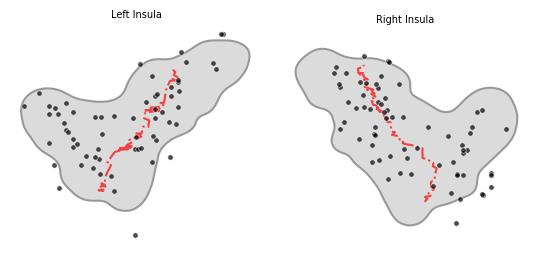

In [26]:
# 不区分颜色，只显示中央沟分界线
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

# 获取所有insula顶点（合并anterior和posterior）
lh_all = np.vstack([regions['lh']['ant'], regions['lh']['post']])
rh_all = np.vstack([regions['rh']['ant'], regions['rh']['post']])

# 计算中央沟边界（两个区域的交界处）
def get_boundary_line(ant_coords, post_coords):
    """找到anterior和posterior区域的边界点"""
    if len(ant_coords) == 0 or len(post_coords) == 0:
        return None
    # 用KDTree找到两个区域最近的点对
    ant_2d = np.column_stack(project_2d(ant_coords))
    post_2d = np.column_stack(project_2d(post_coords))
    
    tree = cKDTree(post_2d)
    dists, _ = tree.query(ant_2d)
    
    # 取距离最近的点作为边界
    threshold = np.percentile(dists, 10)
    boundary_mask = dists <= threshold
    boundary_pts = ant_2d[boundary_mask]
    
    # 按z排序
    if len(boundary_pts) > 0:
        boundary_pts = boundary_pts[boundary_pts[:, 1].argsort()]
    return boundary_pts

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14*cm, 7*cm))

insula_color = '#888888'

for ax, hemi, flip in zip(axes, ['lh', 'rh'], [True, False]):
    all_coords = lh_all if hemi == 'lh' else rh_all
    ant_coords = regions[hemi]['ant']
    post_coords = regions[hemi]['post']
    
    # 绘制整体insula区域（灰色）
    if len(all_coords) > 0:
        draw_smooth_region(np.column_stack(project_2d(all_coords)), ax, insula_color, alpha=0.3)
    
    # 绘制中央沟边界线
    boundary = get_boundary_line(ant_coords, post_coords)
    if boundary is not None and len(boundary) > 5:
        ax.plot(boundary[:, 0], boundary[:, 1], ls='dashdot', linewidth=1.5, alpha=0.7, color='red', label='Central sulcus')
    
    # 绘制电极（统一黑色）
    mask = cord[:, 0] < 0 if hemi == 'lh' else cord[:, 0] > 0
    if mask.any():
        y, z = project_2d(cord[mask])
        ax.scatter(y, z, s=15, c='black', zorder=10, edgecolors='white', linewidths=0.5, alpha=0.7)
    
    ax.set_aspect('equal')
    ax.set_title(f"{'Left' if hemi == 'lh' else 'Right'} Insula", fontsize=fontsize)
    if flip:
        ax.invert_xaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
# plt.savefig('../img/local_insula_no_color.svg', dpi=300, bbox_inches='tight')
plt.show()

# HGA during perception

In [38]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

# 1. 加载所有 perception 和 passive 的 time 数据
task = ['LexicalDelay','PhonemeSequence', 'SentenceRep', 'TIMIT']
# task = ['LexicalDelay']

ref = 'bipolar'
time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',  # 注意这里改成 'time'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename both phase : Resp and Response to Resp
time_data.loc[time_data.phase == 'Resp', 'phase'] = 'Response'
time_data.loc[time_data.phase == 'Response', 'phase'] = 'Response'

# rename phase of perception to audio
time_data.loc[time_data.description == 'passive', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'perception', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'production', 'phase'] = 'Response'

time_data = time_data[time_data.phase=='Audio']

# rename INS to 'Insula'
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'
# combine HG to STG
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'
# rename CG to Cingulate cortex
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

listen_hga = time_data[(time_data['time'] >= 0) & 
                       (time_data['time'] <= 0.5)].groupby('channel').agg({
    'value': 'max',  
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'label': 'first',
    'phase': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'task': 'first'
}).reset_index()

listen_hga.rename(columns={'value': 'HGA'}, inplace=True)
listen_hga.head()

100%|██████████| 975/975 [00:16<00:00, 57.40it/s] 


,channel,HGA,x,y,z,roi,label,phase,hemi,subject,description,task
0,D0005_LTG13-14,0.959813,-67.238742,-17.127162,-3.621204,STG,ctx_lh_G_temp_sup-Lateral,Audio,L,D0005,JL,SentenceRep
1,D0005_LTG14-15,4.551236,-68.886726,-28.295294,0.243498,STG,ctx_lh_G_temp_sup-Lateral,Audio,L,D0005,JL,SentenceRep
2,D0005_LTG15-16,4.435046,-69.639740,-38.151283,4.609248,STG,ctx_lh_G_temp_sup-Lateral,Audio,L,D0005,JL,SentenceRep
3,D0005_LTG16-19,1.151295,-63.894918,-19.994242,-9.960822,MTG,ctx_lh_G_temporal_middle,Audio,L,D0005,JL,SentenceRep
4,D0005_LTG2-3,0.418852,-56.048491,15.454424,-8.878516,STG,ctx_lh_G_temp_sup-Lateral,Audio,L,D0005,JL,SentenceRep


In [39]:
# 先选出 Insula 的 unique 电极
listen_hga = listen_hga[listen_hga.roi.isin(['Insula'])]

# listen_hga = listen_hga[
#     listen_hga.label.str.contains('G_insular_short') |
#     listen_hga.label.str.contains('G_Ins_lg_and_S_cent_ins')
# ]
print(len(listen_hga))
listen_hga

182


,channel,HGA,x,y,z,roi,label,phase,hemi,subject,description,task
18,D0007_RFG1-2,1.611373,57.291674,20.558277,-14.696772,Insula,ctx_rh_G_insular_short,Audio,R,D0007,JL,SentenceRep
19,D0007_RFG11-12,2.937710,64.378501,2.863000,-1.432103,Insula,ctx_rh_S_circular_insula_inf,Audio,R,D0007,JL,SentenceRep
28,D0007_RFG3-4,8.255636,65.593665,3.077178,-13.001741,Insula,ctx_rh_S_circular_insula_inf,Audio,R,D0007,JL,SentenceRep
117,D0022_LPIF3-4,1.641850,-34.587586,-19.677040,-2.311079,Insula,ctx_lh_S_circular_insula_inf,Audio,L,D0022,JL,SentenceRep
118,D0022_LPIF4-5,1.988714,-40.742572,-20.437126,-4.055261,Insula,ctx_lh_S_circular_insula_inf,Audio,L,D0022,JL,SentenceRep
...,...,...,...,...,...,...,...,...,...,...,...,...
3087,D0115_LIA6-7,1.364323,-32.749818,16.893498,12.175728,Insula,ctx_lh_S_circular_insula_sup,Audio,L,D0115,Decision,LexicalDelay
3105,D0115_LTAS3-4,0.780808,-44.646565,-1.235464,-12.425016,Insula,ctx_lh_S_circular_insula_inf,Audio,L,D0115,Decision,LexicalDelay
3108,D0115_LTMS1-2,1.250653,-37.579340,-15.968623,-3.981129,Insula,ctx_lh_S_circular_insula_inf,Audio,L,D0115,Decision,LexicalDelay
3109,D0115_LTMS2-3,1.898640,-41.561672,-15.869995,-3.737251,Insula,ctx_lh_S_circular_insula_inf,Audio,L,D0115,Decision,LexicalDelay


Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-13 18:16:29.337 (1525.058s) [    7F29E5986440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6b893360): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-13 18:16:29.390 (1525.110s) [    7F29E5986440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x669a0550): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

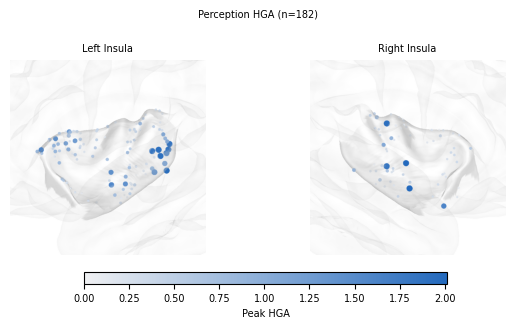

In [40]:
# 3D Insula HGA Visualization (color + size mapped to HGA)
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# HGA数据 - 使用listen_hga
cord = listen_hga[['x', 'y', 'z']].values
hga_values = listen_hga['HGA'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = blues
vmin, vmax = 0, np.percentile(hga_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 8, 25

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

def add_electrodes_with_hga(brain, coords, hga_vals, tree, pial_coords, cmap, norm, size_min, size_max):
    """添加电极，颜色和大小映射到HGA"""
    # 投影到表面
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_hga = hga_values[mask_lh]
    add_electrodes_with_hga(lh_brain, lh_cord, lh_hga, lh_tree, lh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_hga = hga_values[mask_rh]
    add_electrodes_with_hga(rh_brain, rh_cord, rh_hga, rh_tree, rh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Peak HGA', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Perception HGA (n={})".format(len(listen_hga)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

## Plot on 2D

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2863259/317841368.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


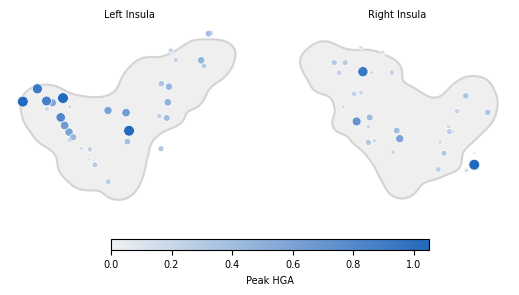

In [76]:
# 2D Insula HGA visualization (color + size mapped to HGA)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

# HGA数据
cord = listen_hga[['x', 'y', 'z']].values
elec_labels = listen_hga['label'].values
hga_values = listen_hga['HGA'].values

# colormap和归一化
cmap = blues
vmin, vmax = 0, np.percentile(hga_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射
size_min, size_max = 2, 60
def hga_to_size(hga):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14*cm, 7*cm))

for ax, hemi, flip in zip(axes, ['lh', 'rh'], [True, False]):
    # 绘制insula区域背景（灰色）
    all_coords = np.vstack([regions[hemi]['ant'], regions[hemi]['post']])
    if len(all_coords) > 0:
        draw_smooth_region(np.column_stack(project_2d(all_coords)), ax, '#CCCCCC', alpha=0.3)
    
    # 绘制电极（颜色和大小映射到HGA）
    mask = cord[:, 0] < 0 if hemi == 'lh' else cord[:, 0] > 0
    if mask.any():
        y, z = project_2d(cord[mask])
        hga = hga_values[mask]
        sizes = hga_to_size(hga)
        colors = cmap(norm(hga))
        ax.scatter(y, z, s=sizes, c=colors, zorder=10, edgecolors='white', linewidths=0.5)
    
    ax.set_aspect('equal')
    ax.set_title(f"{'Left' if hemi == 'lh' else 'Right'} Insula", fontsize=fontsize)
    if flip:
        ax.invert_xaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.15, aspect=30)
cbar.set_label('Peak HGA', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
# plt.savefig('../img/local_insula_hga_2d.svg', dpi=300, bbox_inches='tight')
plt.show()

# HGA during production

In [52]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

# 1. 加载所有 time 数据
task = ['PhonemeSequence', 'SentenceRep', 'TIMIT', 'LexicalDelay']
ref = 'bipolar'

time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',
            check=False,
        ).match()
    )

# 2. 加载数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename both phase : Resp and Response to Resp
time_data.loc[time_data.phase == 'Resp', 'phase'] = 'Response'
time_data.loc[time_data.phase == 'Response', 'phase'] = 'Response'

# rename phase of perception to audio
time_data.loc[time_data.description == 'passive', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'perception', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'production', 'phase'] = 'Response'

time_data = time_data[time_data.phase=='Response']

# rename ROIs
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

# 只保留 time >= -0.5
speak_data = time_data[(time_data['time'] <= 0) & 
                        (time_data['time'] >= -1)]

print(f"筛选后数据量: {len(speak_data)}")
print(f"description 分布: {speak_data.description.unique()}")
print(f"phase 分布: {speak_data.phase.unique()}")
print(f"task 分布: {speak_data.task.unique()}")

# 4. groupby 计算 peak HGA
speak_hga = speak_data.groupby('channel').agg({
    'value': 'mean', 
    'label': 'first', 
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'phase':'first',
    'task':'first'
}).reset_index()

speak_hga.rename(columns={'value': 'HGA'}, inplace=True)
speak_hga['HGA'] = speak_hga['HGA'].astype(float)

speak_hga.head()

100%|██████████| 975/975 [00:17<00:00, 55.24it/s] 


筛选后数据量: 910363
description 分布: ['production' 'LS' 'Decision' 'Repeat']
phase 分布: ['Response']
task 分布: ['PhonemeSequence' 'SentenceRep' 'LexicalDelay']


,channel,HGA,label,x,y,z,roi,hemi,subject,description,phase,task
0,D0005_LTG14-15,-0.072873,ctx_lh_G_temp_sup-Lateral,-68.886726,-28.295294,0.243498,STG,L,D0005,LS,Response,SentenceRep
1,D0005_LTG15-16,-0.176992,ctx_lh_G_temp_sup-Lateral,-69.639740,-38.151283,4.609248,STG,L,D0005,LS,Response,SentenceRep
2,D0005_LTG24-26,0.084555,ctx_lh_G_temporal_inf,-57.666666,-21.463809,-25.843526,ITG,L,D0005,LS,Response,SentenceRep
3,D0005_LTG29-30,0.183034,ctx_lh_G_temporal_inf,-54.534528,-29.265764,-28.078430,ITG,L,D0005,LS,Response,SentenceRep
4,D0005_LTG30-31,0.258022,ctx_lh_G_temporal_inf,-55.770381,-38.615740,-23.875112,ITG,L,D0005,LS,Response,SentenceRep


In [53]:
speak_hga = speak_hga[speak_hga.roi=='Insula']

# speak_hga = speak_hga[
#     speak_hga.label.str.contains('G_insular_short') |
#     speak_hga.label.str.contains('G_Ins_lg_and_S_cent_ins')
# ]
print(len(speak_hga))
speak_hga.head()

139


,channel,HGA,label,x,y,z,roi,hemi,subject,description,phase,task
17,D0007_RFG1-2,0.103657,ctx_rh_G_insular_short,57.291674,20.558277,-14.696772,Insula,R,D0007,LS,Response,SentenceRep
18,D0007_RFG11-12,0.457489,ctx_rh_S_circular_insula_inf,64.378501,2.863000,-1.432103,Insula,R,D0007,LS,Response,SentenceRep
30,D0007_RFG3-4,0.068521,ctx_rh_S_circular_insula_inf,65.593665,3.077178,-13.001741,Insula,R,D0007,LS,Response,SentenceRep
146,D0022_LPIF3-4,0.086543,ctx_lh_S_circular_insula_inf,-34.587586,-19.677040,-2.311079,Insula,L,D0022,production,Response,PhonemeSequence
147,D0022_LPIF4-5,0.130514,ctx_lh_S_circular_insula_inf,-40.742572,-20.437126,-4.055261,Insula,L,D0022,LS,Response,SentenceRep


Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-13 19:44:45.914 (6821.635s) [    7F29E5986440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x25fae580): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-13 19:44:45.976 (6821.696s) [    7F29E5986440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x47a38f90): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

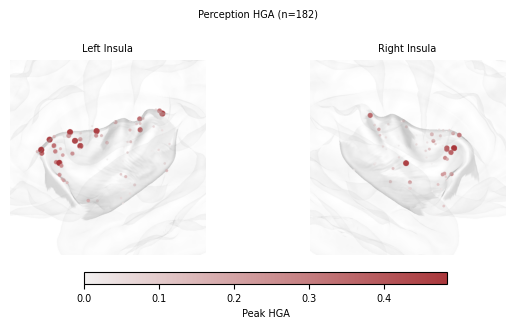

In [55]:
# 3D Insula HGA Visualization (color + size mapped to HGA)
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# HGA数据 - 使用listen_hga
cord = speak_hga[['x', 'y', 'z']].values
hga_values = speak_hga['HGA'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
vmin, vmax = 0, np.percentile(hga_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 8, 25

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

def add_electrodes_with_hga(brain, coords, hga_vals, tree, pial_coords, cmap, norm, size_min, size_max):
    """添加电极，颜色和大小映射到HGA"""
    # 投影到表面
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_hga = hga_values[mask_lh]
    add_electrodes_with_hga(lh_brain, lh_cord, lh_hga, lh_tree, lh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_hga = hga_values[mask_rh]
    add_electrodes_with_hga(rh_brain, rh_cord, rh_hga, rh_tree, rh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1, aspect=30)
cbar.set_label('Peak HGA', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Perception HGA (n={})".format(len(listen_hga)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

/hpc/home/ns458/coganlab/nanlinshi/tmp/ipykernel_2863259/2043617185.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


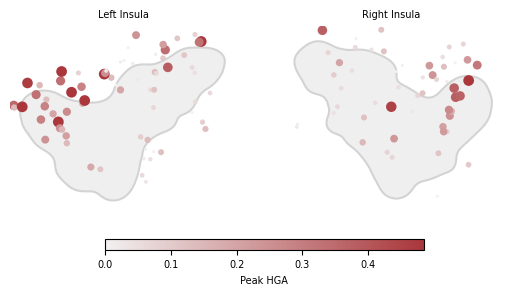

In [86]:
# 2D Insula HGA visualization (color + size mapped to HGA)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

# HGA数据
cord = speak_hga[['x', 'y', 'z']].values
elec_labels = speak_hga['label'].values
hga_values = speak_hga['HGA'].values

# colormap和归一化
cmap = reds
vmin, vmax = 0, np.percentile(hga_values, 95)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射
size_min, size_max = 5, 60
def hga_to_size(hga):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(14*cm, 7*cm))

for ax, hemi, flip in zip(axes, ['lh', 'rh'], [True, False]):
    # 绘制insula区域背景（灰色）
    all_coords = np.vstack([regions[hemi]['ant'], regions[hemi]['post']])
    if len(all_coords) > 0:
        draw_smooth_region(np.column_stack(project_2d(all_coords)), ax, '#CCCCCC', alpha=0.3)
    
    # 绘制电极（颜色和大小映射到HGA）
    mask = cord[:, 0] < 0 if hemi == 'lh' else cord[:, 0] > 0
    if mask.any():
        y, z = project_2d(cord[mask])
        hga = hga_values[mask]
        sizes = hga_to_size(hga)
        colors = cmap(norm(hga))
        ax.scatter(y, z, s=sizes, c=colors, zorder=10, edgecolors='None', linewidths=0.75)
    
    ax.set_aspect('equal')
    ax.set_title(f"{'Left' if hemi == 'lh' else 'Right'} Insula", fontsize=fontsize)
    if flip:
        ax.invert_xaxis()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.15, aspect=30)
cbar.set_label('Peak HGA', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
# plt.savefig('../img/local_insula_hga_2d.svg', dpi=300, bbox_inches='tight')
plt.show()